In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import shap #Feature importance graph
import warnings

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from catboost import Pool, CatBoostRegressor, cv #catboost
from sklearn.model_selection import train_test_split #as it is

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warning from sklearn and seaborn

In [2]:
train = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape


(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Deleting outliers

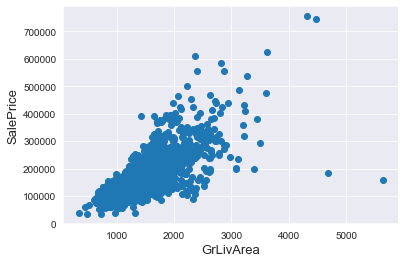

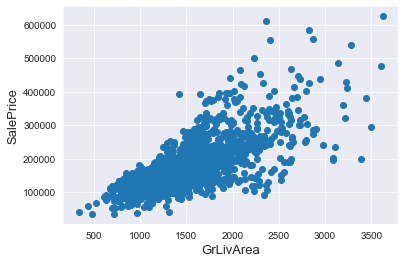

In [6]:
#show outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


# Check and normalize the distribution


 mu = 180151.23 and sigma = 76670.25



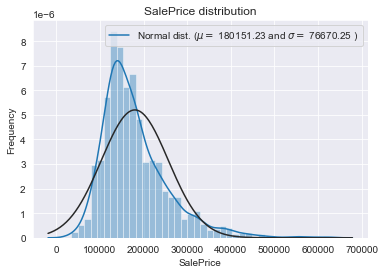

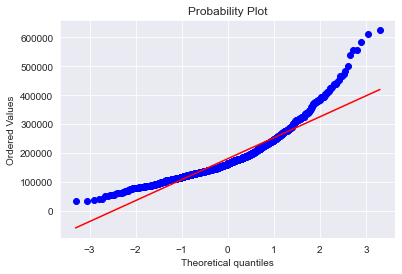

In [7]:
#SalePrice exploration
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()



 mu = 12.02 and sigma = 0.40



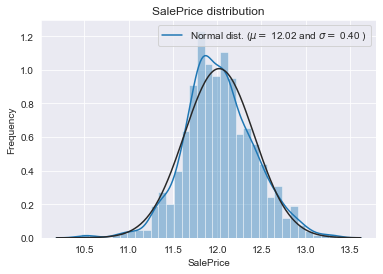

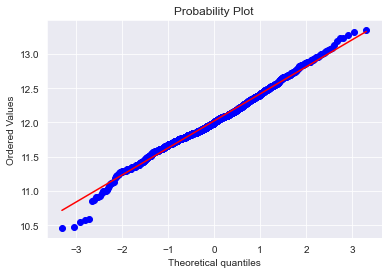

In [8]:
#The numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# Feature engineering

In [9]:
#concatenate data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 79)


In [10]:
#calculate % of missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


<AxesSubplot:>

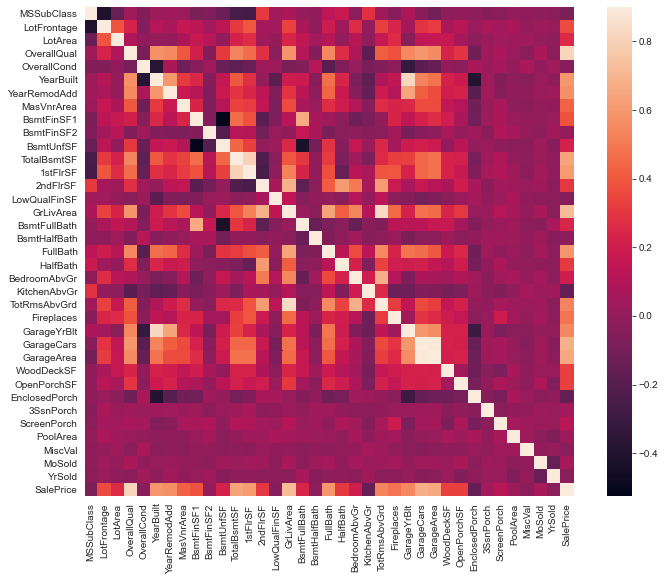

In [11]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [12]:
#fill up missing values


#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#Check whether it should be None or 0
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt','MasVnrArea', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MasVnrType','Electrical','Exterior1st', 'Exterior2nd','MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#for Functional NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [13]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [14]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal


In [15]:
#Transforming some numerical variables that are really categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(int)

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


#Since area features are really important we can add one more as a sum.Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Getting new train and test set

In [16]:
#rows from train dataset
train = all_data[:ntrain]
#rows since train dataset (test)
test = all_data[ntrain:]

# Catboost

In [17]:
#Select all the categorial features

feat= np.where(train.dtypes == object)[0]
#split
X_train, X_val, y_train, y_val = train_test_split(train, y_train, train_size=0.8, random_state=1234)

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=feat)
val_pool = Pool(X_val, y_val,
                 cat_features=feat) 

test_pool = Pool(test, cat_features = feat)


# Parameter tuning

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.05, 0.08, 0.1],
        'max_depth': [4, 6,8, 10],
        'l2_leaf_reg': [1, 3, 6, 8, 9],
        'random_strength': [0.5, 1, 2, 4]}

                                   
                                     
randomized_search_result = model.randomized_search(grid,
                                                   train_pool,
                                                   plot=True)


In [18]:
model = CatBoostRegressor(loss_function='RMSE', 
                                    use_best_model = True,
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.08,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide')



In [19]:
model.fit(train_pool, eval_set = val_pool)
print ('Model is fitted:', model.is_fitted())
print ('Model params:', model.get_params())
print ('Resulting tree count:', model.tree_count_)

0:	learn: 0.3813758	test: 0.3512628	best: 0.3512628 (0)	total: 95.6ms	remaining: 1m 35s
1:	learn: 0.3624765	test: 0.3336239	best: 0.3336239 (1)	total: 131ms	remaining: 1m 5s
2:	learn: 0.3458978	test: 0.3182710	best: 0.3182710 (2)	total: 168ms	remaining: 55.9s
3:	learn: 0.3303033	test: 0.3042137	best: 0.3042137 (3)	total: 227ms	remaining: 56.4s
4:	learn: 0.3142022	test: 0.2899169	best: 0.2899169 (4)	total: 295ms	remaining: 58.6s
5:	learn: 0.2990222	test: 0.2765077	best: 0.2765077 (5)	total: 355ms	remaining: 58.7s
6:	learn: 0.2852682	test: 0.2649536	best: 0.2649536 (6)	total: 390ms	remaining: 55.3s
7:	learn: 0.2734953	test: 0.2545439	best: 0.2545439 (7)	total: 427ms	remaining: 53s
8:	learn: 0.2617130	test: 0.2450336	best: 0.2450336 (8)	total: 463ms	remaining: 51s
9:	learn: 0.2517843	test: 0.2364055	best: 0.2364055 (9)	total: 508ms	remaining: 50.3s
10:	learn: 0.2424208	test: 0.2289739	best: 0.2289739 (10)	total: 554ms	remaining: 49.8s
11:	learn: 0.2333522	test: 0.2212392	best: 0.2212392 (

97:	learn: 0.0892774	test: 0.1308288	best: 0.1308288 (97)	total: 6.25s	remaining: 57.5s
98:	learn: 0.0888887	test: 0.1308345	best: 0.1308288 (97)	total: 6.3s	remaining: 57.4s
99:	learn: 0.0884970	test: 0.1308054	best: 0.1308054 (99)	total: 6.35s	remaining: 57.1s
100:	learn: 0.0880864	test: 0.1306088	best: 0.1306088 (100)	total: 6.39s	remaining: 56.9s
101:	learn: 0.0878388	test: 0.1305711	best: 0.1305711 (101)	total: 6.48s	remaining: 57.1s
102:	learn: 0.0875218	test: 0.1303284	best: 0.1303284 (102)	total: 6.53s	remaining: 56.9s
103:	learn: 0.0872368	test: 0.1301627	best: 0.1301627 (103)	total: 6.57s	remaining: 56.6s
104:	learn: 0.0868389	test: 0.1301460	best: 0.1301460 (104)	total: 6.61s	remaining: 56.3s
105:	learn: 0.0865611	test: 0.1300587	best: 0.1300587 (105)	total: 6.65s	remaining: 56.1s
106:	learn: 0.0863486	test: 0.1299957	best: 0.1299957 (106)	total: 6.72s	remaining: 56.1s
107:	learn: 0.0860274	test: 0.1297855	best: 0.1297855 (107)	total: 6.78s	remaining: 56s
108:	learn: 0.08582

191:	learn: 0.0707680	test: 0.1283444	best: 0.1283044 (187)	total: 11.3s	remaining: 47.4s
192:	learn: 0.0707143	test: 0.1283379	best: 0.1283044 (187)	total: 11.4s	remaining: 47.6s
193:	learn: 0.0705795	test: 0.1283626	best: 0.1283044 (187)	total: 11.5s	remaining: 47.6s
194:	learn: 0.0704507	test: 0.1283165	best: 0.1283044 (187)	total: 11.5s	remaining: 47.7s
195:	learn: 0.0702087	test: 0.1283208	best: 0.1283044 (187)	total: 11.6s	remaining: 47.6s
196:	learn: 0.0701285	test: 0.1283722	best: 0.1283044 (187)	total: 11.7s	remaining: 47.6s
197:	learn: 0.0700350	test: 0.1282995	best: 0.1282995 (197)	total: 11.7s	remaining: 47.5s
198:	learn: 0.0697608	test: 0.1282652	best: 0.1282652 (198)	total: 11.8s	remaining: 47.4s
199:	learn: 0.0694512	test: 0.1281101	best: 0.1281101 (199)	total: 11.8s	remaining: 47.3s
200:	learn: 0.0693623	test: 0.1281167	best: 0.1281101 (199)	total: 11.9s	remaining: 47.3s
201:	learn: 0.0692776	test: 0.1281189	best: 0.1281101 (199)	total: 12s	remaining: 47.3s
202:	learn: 

283:	learn: 0.0586262	test: 0.1270156	best: 0.1269465 (264)	total: 18.2s	remaining: 45.8s
284:	learn: 0.0584899	test: 0.1270284	best: 0.1269465 (264)	total: 18.2s	remaining: 45.7s
285:	learn: 0.0583717	test: 0.1269714	best: 0.1269465 (264)	total: 18.3s	remaining: 45.6s
286:	learn: 0.0582226	test: 0.1269423	best: 0.1269423 (286)	total: 18.3s	remaining: 45.5s
287:	learn: 0.0580874	test: 0.1269628	best: 0.1269423 (286)	total: 18.4s	remaining: 45.4s
288:	learn: 0.0578570	test: 0.1269025	best: 0.1269025 (288)	total: 18.4s	remaining: 45.4s
289:	learn: 0.0577995	test: 0.1269051	best: 0.1269025 (288)	total: 18.5s	remaining: 45.2s
290:	learn: 0.0577241	test: 0.1269144	best: 0.1269025 (288)	total: 18.5s	remaining: 45.1s
291:	learn: 0.0576123	test: 0.1269247	best: 0.1269025 (288)	total: 18.6s	remaining: 45s
292:	learn: 0.0573922	test: 0.1269070	best: 0.1269025 (288)	total: 18.6s	remaining: 45s
293:	learn: 0.0573176	test: 0.1269347	best: 0.1269025 (288)	total: 18.7s	remaining: 44.9s
294:	learn: 0.

375:	learn: 0.0492274	test: 0.1271940	best: 0.1266540 (315)	total: 29.8s	remaining: 49.4s
376:	learn: 0.0491010	test: 0.1271582	best: 0.1266540 (315)	total: 29.9s	remaining: 49.4s
377:	learn: 0.0489690	test: 0.1271749	best: 0.1266540 (315)	total: 29.9s	remaining: 49.3s
378:	learn: 0.0487286	test: 0.1271453	best: 0.1266540 (315)	total: 30s	remaining: 49.1s
379:	learn: 0.0486375	test: 0.1271465	best: 0.1266540 (315)	total: 30s	remaining: 49s
380:	learn: 0.0485692	test: 0.1271285	best: 0.1266540 (315)	total: 30.1s	remaining: 48.9s
381:	learn: 0.0484443	test: 0.1271035	best: 0.1266540 (315)	total: 30.1s	remaining: 48.7s
382:	learn: 0.0483224	test: 0.1270638	best: 0.1266540 (315)	total: 30.2s	remaining: 48.6s
383:	learn: 0.0482960	test: 0.1271015	best: 0.1266540 (315)	total: 30.2s	remaining: 48.5s
384:	learn: 0.0482025	test: 0.1270672	best: 0.1266540 (315)	total: 30.2s	remaining: 48.3s
385:	learn: 0.0481073	test: 0.1270324	best: 0.1266540 (315)	total: 30.3s	remaining: 48.2s
386:	learn: 0.04

468:	learn: 0.0417673	test: 0.1267670	best: 0.1266540 (315)	total: 34.1s	remaining: 38.6s
469:	learn: 0.0416230	test: 0.1267658	best: 0.1266540 (315)	total: 34.2s	remaining: 38.5s
470:	learn: 0.0415153	test: 0.1267251	best: 0.1266540 (315)	total: 34.2s	remaining: 38.4s
471:	learn: 0.0414486	test: 0.1267137	best: 0.1266540 (315)	total: 34.2s	remaining: 38.3s
472:	learn: 0.0413877	test: 0.1267232	best: 0.1266540 (315)	total: 34.3s	remaining: 38.2s
473:	learn: 0.0412598	test: 0.1266949	best: 0.1266540 (315)	total: 34.3s	remaining: 38.1s
474:	learn: 0.0411958	test: 0.1266745	best: 0.1266540 (315)	total: 34.4s	remaining: 38s
475:	learn: 0.0411427	test: 0.1266429	best: 0.1266429 (475)	total: 34.4s	remaining: 37.9s
476:	learn: 0.0411295	test: 0.1266384	best: 0.1266384 (476)	total: 34.4s	remaining: 37.8s
477:	learn: 0.0410659	test: 0.1266623	best: 0.1266384 (476)	total: 34.5s	remaining: 37.7s
478:	learn: 0.0409975	test: 0.1266384	best: 0.1266384 (476)	total: 34.5s	remaining: 37.5s
479:	learn: 

564:	learn: 0.0355944	test: 0.1266341	best: 0.1265339 (527)	total: 38.2s	remaining: 29.4s
565:	learn: 0.0354960	test: 0.1266701	best: 0.1265339 (527)	total: 38.3s	remaining: 29.3s
566:	learn: 0.0354129	test: 0.1266771	best: 0.1265339 (527)	total: 38.3s	remaining: 29.3s
567:	learn: 0.0353440	test: 0.1266933	best: 0.1265339 (527)	total: 38.3s	remaining: 29.2s
568:	learn: 0.0352727	test: 0.1266651	best: 0.1265339 (527)	total: 38.4s	remaining: 29.1s
569:	learn: 0.0352025	test: 0.1266693	best: 0.1265339 (527)	total: 38.4s	remaining: 29s
570:	learn: 0.0351644	test: 0.1266560	best: 0.1265339 (527)	total: 38.5s	remaining: 28.9s
571:	learn: 0.0351133	test: 0.1266494	best: 0.1265339 (527)	total: 38.5s	remaining: 28.8s
572:	learn: 0.0350371	test: 0.1266160	best: 0.1265339 (527)	total: 38.6s	remaining: 28.8s
573:	learn: 0.0350106	test: 0.1266241	best: 0.1265339 (527)	total: 38.6s	remaining: 28.7s
574:	learn: 0.0349449	test: 0.1266243	best: 0.1265339 (527)	total: 38.7s	remaining: 28.6s
575:	learn: 

659:	learn: 0.0307450	test: 0.1262268	best: 0.1262268 (659)	total: 42.6s	remaining: 21.9s
660:	learn: 0.0306812	test: 0.1262170	best: 0.1262170 (660)	total: 42.6s	remaining: 21.9s
661:	learn: 0.0306608	test: 0.1262233	best: 0.1262170 (660)	total: 42.6s	remaining: 21.8s
662:	learn: 0.0306350	test: 0.1262223	best: 0.1262170 (660)	total: 42.7s	remaining: 21.7s
663:	learn: 0.0305630	test: 0.1262619	best: 0.1262170 (660)	total: 42.7s	remaining: 21.6s
664:	learn: 0.0304962	test: 0.1262736	best: 0.1262170 (660)	total: 42.8s	remaining: 21.5s
665:	learn: 0.0304370	test: 0.1262602	best: 0.1262170 (660)	total: 42.8s	remaining: 21.5s
666:	learn: 0.0303420	test: 0.1262638	best: 0.1262170 (660)	total: 42.9s	remaining: 21.4s
667:	learn: 0.0303171	test: 0.1262635	best: 0.1262170 (660)	total: 42.9s	remaining: 21.3s
668:	learn: 0.0302114	test: 0.1262478	best: 0.1262170 (660)	total: 42.9s	remaining: 21.2s
669:	learn: 0.0301855	test: 0.1262534	best: 0.1262170 (660)	total: 43s	remaining: 21.2s
670:	learn: 

756:	learn: 0.0268146	test: 0.1262373	best: 0.1262023 (751)	total: 46.6s	remaining: 14.9s
757:	learn: 0.0267891	test: 0.1262420	best: 0.1262023 (751)	total: 46.6s	remaining: 14.9s
758:	learn: 0.0267786	test: 0.1262306	best: 0.1262023 (751)	total: 46.6s	remaining: 14.8s
759:	learn: 0.0267420	test: 0.1262528	best: 0.1262023 (751)	total: 46.7s	remaining: 14.8s
760:	learn: 0.0266972	test: 0.1262655	best: 0.1262023 (751)	total: 47.1s	remaining: 14.8s
761:	learn: 0.0266455	test: 0.1262593	best: 0.1262023 (751)	total: 47.4s	remaining: 14.8s
762:	learn: 0.0266088	test: 0.1262366	best: 0.1262023 (751)	total: 47.5s	remaining: 14.7s
763:	learn: 0.0265777	test: 0.1262392	best: 0.1262023 (751)	total: 47.5s	remaining: 14.7s
764:	learn: 0.0265701	test: 0.1262386	best: 0.1262023 (751)	total: 47.6s	remaining: 14.6s
765:	learn: 0.0265319	test: 0.1262499	best: 0.1262023 (751)	total: 47.7s	remaining: 14.6s
766:	learn: 0.0265137	test: 0.1262350	best: 0.1262023 (751)	total: 47.9s	remaining: 14.5s
767:	learn

851:	learn: 0.0237126	test: 0.1263338	best: 0.1261814 (773)	total: 53s	remaining: 9.2s
852:	learn: 0.0236555	test: 0.1263606	best: 0.1261814 (773)	total: 53s	remaining: 9.13s
853:	learn: 0.0236444	test: 0.1263607	best: 0.1261814 (773)	total: 53s	remaining: 9.07s
854:	learn: 0.0236319	test: 0.1263582	best: 0.1261814 (773)	total: 53.1s	remaining: 9s
855:	learn: 0.0236126	test: 0.1263547	best: 0.1261814 (773)	total: 53.1s	remaining: 8.94s
856:	learn: 0.0235670	test: 0.1263593	best: 0.1261814 (773)	total: 53.2s	remaining: 8.87s
857:	learn: 0.0235391	test: 0.1263530	best: 0.1261814 (773)	total: 53.2s	remaining: 8.8s
858:	learn: 0.0234817	test: 0.1263072	best: 0.1261814 (773)	total: 53.2s	remaining: 8.74s
859:	learn: 0.0234455	test: 0.1262942	best: 0.1261814 (773)	total: 53.3s	remaining: 8.68s
860:	learn: 0.0234388	test: 0.1262941	best: 0.1261814 (773)	total: 53.3s	remaining: 8.61s
861:	learn: 0.0234311	test: 0.1262926	best: 0.1261814 (773)	total: 53.4s	remaining: 8.54s
862:	learn: 0.0234099

943:	learn: 0.0214646	test: 0.1263371	best: 0.1261814 (773)	total: 1m 5s	remaining: 3.88s
944:	learn: 0.0214419	test: 0.1263264	best: 0.1261814 (773)	total: 1m 5s	remaining: 3.81s
945:	learn: 0.0214249	test: 0.1263322	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.79s
946:	learn: 0.0214164	test: 0.1263278	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.72s
947:	learn: 0.0213744	test: 0.1263162	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.65s
948:	learn: 0.0213697	test: 0.1263130	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.58s
949:	learn: 0.0213571	test: 0.1263161	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.51s
950:	learn: 0.0213432	test: 0.1263088	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.44s
951:	learn: 0.0213197	test: 0.1263139	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.37s
952:	learn: 0.0212810	test: 0.1263170	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.3s
953:	learn: 0.0212374	test: 0.1263111	best: 0.1261814 (773)	total: 1m 6s	remaining: 3.23s
954:	learn:

# Cross validation

In [20]:
params = model.get_params()
params['iterations'] = 5
params['custom_loss'] = 'RMSE'


cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=2,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0
)



np.set_printoptions(precision=3)

for name, values in cv_data.iteritems():
    print (name + ':')
    print (np.array(values))

0:	learn: 11.1356317	test: 11.1390704	best: 11.1390704 (0)	total: 62ms	remaining: 248ms
1:	learn: 10.3129986	test: 10.3078771	best: 10.3078771 (1)	total: 118ms	remaining: 177ms
2:	learn: 9.5540444	test: 9.5635068	best: 9.5635068 (2)	total: 204ms	remaining: 136ms
3:	learn: 8.8393759	test: 8.8444312	best: 8.8444312 (3)	total: 261ms	remaining: 65.2ms
4:	learn: 8.1893980	test: 8.1884668	best: 8.1884668 (4)	total: 339ms	remaining: 0us
iterations:
[0 1 2 3 4]
test-RMSE-mean:
[11.139 10.308  9.564  8.844  8.188]
test-RMSE-std:
[0.01  0.047 0.035 0.056 0.069]
train-RMSE-mean:
[11.136 10.313  9.554  8.839  8.189]
train-RMSE-std:
[0.015 0.019 0.024 0.033 0.038]


# Model performance evaluation

In [21]:
best_value = np.max(cv_data['test-RMSE-mean'])
best_iter = np.argmax(cv_data['test-RMSE-mean'])
print ('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    best_value,
    cv_data['test-RMSE-std'][best_iter],
    best_iter
))

Best validation RMSE score: 11.14±0.01 on step 0


Feature importances: [6.023e-01 1.022e+00 3.712e-01 1.285e+00 4.270e-02 2.001e-02 1.111e-01
 7.534e-02 4.702e-05 5.334e-02 2.554e-02 4.511e-01 5.618e-02 5.674e-03
 1.318e-01 7.543e-02 2.856e+01 1.033e+00 3.020e+00 1.600e+00 1.454e-01
 3.539e-03 1.878e-01 1.213e-01 4.064e-02 7.561e-02 2.001e+00 7.196e-02
 1.910e-01 7.454e-01 1.097e-01 4.972e-01 1.866e-01 1.043e+00 3.132e-02
 6.204e-02 3.893e-01 4.057e-01 9.890e-03 1.641e-01 1.021e+00 4.213e-02
 1.713e+00 2.185e-01 3.538e-02 2.207e+00 1.577e-01 4.342e-02 5.500e-01
 2.208e-01 2.202e-01 2.761e-02 5.507e+00 2.529e-01 2.031e-01 1.238e+00
 1.429e+00 2.483e-01 4.550e-01 9.961e-01 1.535e+00 2.721e+00 3.740e-01
 3.246e-01 1.229e-01 3.083e-01 3.595e-01 5.885e-02 1.286e-02 7.470e-02
 5.695e-03 1.150e-02 7.076e-02 3.415e-03 1.349e-03 1.920e-01 7.114e-02
 5.448e-02 2.621e-01 3.162e+01]
Feature names: ['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condit

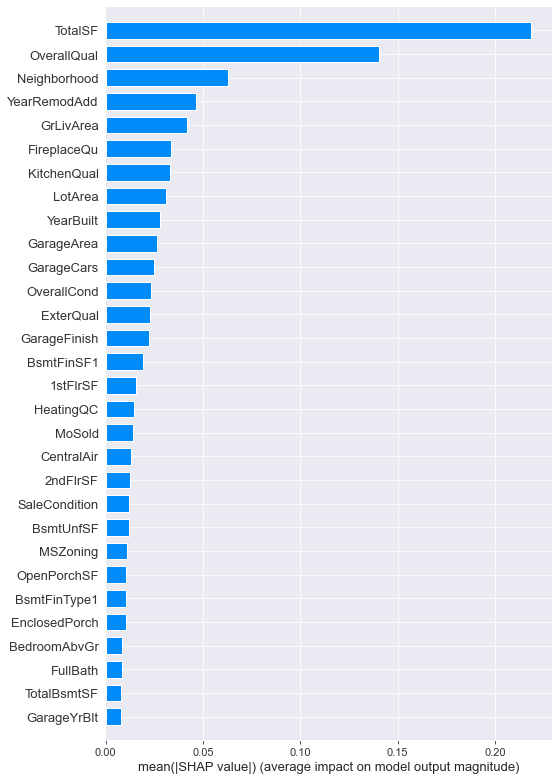

In [22]:
# Feature importance check, just because I can
importances = model.feature_importances_
print ('Feature importances:', np.array(importances))
print ('Feature names:', np.array(train_pool.get_feature_names()))



shap_values = model.get_feature_importance(train_pool, type='ShapValues')
shap.summary_plot(shap_values[:,:-1], X_train, plot_type='bar', max_display=30)

# Prediction and submission

In [29]:
x = model.predict(test_pool)
x

array([11.766, 11.973, 12.164, ..., 11.97 , 11.703, 12.266])

In [28]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = x
sub.to_csv('submission1.csv',index=False)

In [27]:
submission = pd.DataFrame({'Id': test_ID,'SalePrice':x})
#save the file to your directory
submission.to_csv('submission.csv',index=False)